In [19]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_validate
import matplotlib.pyplot as plt
%matplotlib inline

## Leitura do dataset

In [41]:
dataset = pd.read_csv('coverage-dataset.csv', sep=';')
dataset.head(5)

,Name,CountInput,CountLine,CountLineBlank,CountLineCode,CountLineCodeDecl,CountLineCodeExe,CountLineComment,CountOutput,CountPath,...,CyclomaticStrict.1,Essential.1,Knots.1,MaxEssentialKnots.1,MaxNesting.1,MinEssentialKnots.1,RatioCommentToCode.1,EdgeCoverage,PrimePathCoverage,Unnamed: 50
0,org.biojava.nbio.alignment.GuideTree.getAllPai...,2,13,0,8,3,5,5,3,2,...,1,1,0,0,0,0,0.00,"1,0000","0,8000",NaN
1,org.biojava.nbio.alignment.GuideTree.getDistan...,3,14,0,9,2,5,5,3,3,...,1,1,0,0,0,0,0.00,"1,0000","0,7143",NaN
2,org.biojava.nbio.alignment.GuideTree.getScoreM...,4,15,0,10,2,6,5,5,3,...,1,1,0,0,0,0,0.00,"1,0000","0,7000",NaN
3,org.biojava.nbio.alignment.SimpleGapPenalty.se...,2,7,0,4,1,2,3,3,1,...,2,1,1,0,1,0,0.29,"1,0000","1,0000",NaN
4,org.biojava.nbio.alignment.SimpleGapPenalty.se...,2,7,0,4,1,2,3,3,1,...,2,1,1,0,1,0,0.29,"1,0000","1,0000",NaN


## Pré-processamento

In [42]:
# Remove ultima coluna vazia
dataset = dataset.iloc[:,:-1]

# Remove NaN
dataset = dataset.dropna()

# Converte valores de cobertura em float
dataset.iloc[:,-1] = dataset.iloc[:,-1].apply(lambda ppc: float(ppc.replace(',', '.')))
dataset.iloc[:,-2] = dataset.iloc[:,-2].apply(lambda ec: float(ec.replace(',', '.')))

# Remove valores de cobertura zerados
dataset = dataset[dataset['EdgeCoverage'] > 0]
dataset = dataset[dataset['PrimePathCoverage'] > 0]

## Under-sampling

Dataset size:  2167
Média complexidade dataset:  3.446528555431131
Média complexidade dataset balanceado:  5.032764190124596


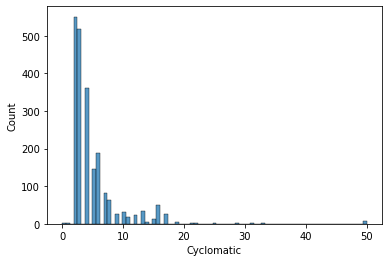

In [43]:
from imblearn.under_sampling import RandomUnderSampler

# usa técnica under-sampling
def under_sampling(d, seed = 0):
    ppc = d['PrimePathCoverage'].values
    rus = RandomUnderSampler(random_state=seed, sampling_strategy='majority')
    X_res, y_res = rus.fit_resample(d['Name'].values.reshape(-1,1), d['Cyclomatic'].values)
    d['Selected'] = d['Name'].apply(lambda name: name in X_res)
    dataset_filtered = d[d['Selected']]
    dataset_filtered = dataset_filtered.drop('Selected', axis=1)
    d = d.drop('Selected', axis=1)
    
    return dataset_filtered

dataset_filtered = under_sampling(dataset, 0)
print('Dataset size: ', dataset_filtered.shape[0])
sns.histplot(dataset_filtered['Cyclomatic'])

print('Média complexidade dataset: ', dataset['Cyclomatic'].mean())
print('Média complexidade dataset balanceado: ', dataset_filtered['Cyclomatic'].mean())

## Funções uteis

In [44]:
from sklearn.preprocessing import MinMaxScaler

k = 10
metricas_erro = [
    'r2', 'max_error', 'neg_mean_absolute_error',
    'neg_mean_squared_error', 'neg_root_mean_squared_error',
    'neg_mean_squared_log_error', 'neg_median_absolute_error'
]
previsores = [
    # Método testado
    'CountInput','CountLine','CountLineCode','CountLineCodeDecl',
    'CountLineCodeExe','CountLineComment','CountOutput','CountStmt',
    'CountStmtDecl','CountPath','CountPathLog','CountStmtExe',
    'Cyclomatic','CyclomaticModified','CyclomaticStrict','Essential',
    'Knots','MaxEssentialKnots','MaxNesting','MinEssentialKnots','EdgeCoverage',
    
    # Método de teste
    'CountInput.1','CountLine.1','CountLineBlank.1',
    'CountLineCode.1','CountLineCodeDecl.1','CountLineCodeExe.1',
    'CountOutput.1','CountStmt.1', 'CountStmtDecl.1',
    'CountStmtExe.1','Cyclomatic.1'
]

def escalonador(dados):
    scaler = MinMaxScaler()
    return scaler.fit_transform(dados)

def evaluate(previsores, classificador, d = dataset_filtered, k=10):
    ppc = d['PrimePathCoverage'].values
    previsores_content = d[previsores].values
    resultados = cross_validate(
            classificador, 
            previsores_content, 
            ppc, 
            cv=k, 
            scoring=metricas_erro, 
            return_estimator=True
    )
    resultados_escalonados = cross_validate(
            classificador, 
            escalonador(previsores_content), 
            ppc, 
            cv=k, 
            scoring=metricas_erro, 
            return_estimator=True
    )
    
    #print(ppc)
    #print(previsores_content)
    print(resultados)
    
    print('-----< SEM ESCALONAMENTO >-----')
    print('Mean Abs Error: ', abs(resultados['test_neg_mean_absolute_error'].mean()))
    print('Mean Sqr Error: ', abs(resultados['test_neg_mean_squared_error'].mean()))
    print('Mean Sqr Log Error: ', abs(resultados['test_neg_mean_squared_log_error'].mean()))
    print('Mean Median Error: ', abs(resultados['test_neg_median_absolute_error'].mean()))
    print('R2 Score: ', abs(resultados['test_r2'].mean()))
    print('-----< COM ESCALONAMENTO >-----')
    print('Mean Abs Error: ', abs(resultados_escalonados['test_neg_mean_absolute_error'].mean()))
    print('Mean Sqr Error: ', abs(resultados_escalonados['test_neg_mean_squared_error'].mean()))
    print('Mean Sqr Log Error: ', abs(resultados_escalonados['test_neg_mean_squared_log_error'].mean()))
    print('Mean Median Error: ', abs(resultados_escalonados['test_neg_median_absolute_error'].mean()))
    print('R2 Score: ', abs(resultados_escalonados['test_r2'].mean()))

## Experimentos

In [34]:
dataset_filtered[dataset_filtered[previsores].values < 0]

,Name,CountInput,CountLine,CountLineBlank,CountLineCode,CountLineCodeDecl,CountLineCodeExe,CountLineComment,CountOutput,CountPath,...,CyclomaticModified.1,CyclomaticStrict.1,Essential.1,Knots.1,MaxEssentialKnots.1,MaxNesting.1,MinEssentialKnots.1,RatioCommentToCode.1,EdgeCoverage,PrimePathCoverage


In [45]:
evaluate([
    'Cyclomatic',
    'EdgeCoverage'
], GaussianNB(), dataset_filtered)

{'fit_time': array([0.00288224, 0.00400352, 0.00309372, 0.00377631, 0.00424099,
       0.00305891, 0.00401664, 0.00610185, 0.00295949, 0.0038898 ]), 'score_time': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'estimator': [GaussianNB(), GaussianNB(), GaussianNB(), GaussianNB(), GaussianNB(), GaussianNB(), GaussianNB(), GaussianNB(), GaussianNB(), GaussianNB()], 'test_r2': array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]), 'test_max_error': array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]), 'test_neg_mean_absolute_error': array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]), 'test_neg_mean_squared_error': array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]), 'test_neg_root_mean_squared_error': array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]), 'test_neg_mean_squared_log_error': array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]), 'test_neg_median_absolute_error': array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])}
-----< SEM ESCALONAMENT

C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\naive_bayes.py", line 209, in fit
    return self._partial_fit(X, y, np.unique(y), _refit=True,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\naive_bayes.py", line 374, in _partial_fit
    if _check_partial_fit_first_call(self, classes):
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\utils\multiclass.py", line 339, in _check_partial_fit_first_call
    clf.classes_ = unique_labels(classes)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\utils\multiclass.py", line 98, in uni